In [ ]:
# Connect colab to Drive
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [ ]:
# Import libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import seaborn as sns
sns.set_style("darkgrid")

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


## Exploration

In [ ]:
# Load our datasets
df = pd.read_csv("/content/drive/MyDrive/Datasets/application_record.csv", encoding='utf-8') 
credit_record = pd.read_csv("/content/drive/MyDrive/Datasets/credit_record.csv", encoding='utf-8') 

In [ ]:
# Shape of application_record dataset
print("Shape of application records: %d" % len(df))
print("Total number of unique customers: %d" % len(df.ID.unique()))
df.head()

Shape of application records: 438557
Total number of unique customers: 438510


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
# Shape of credit_record dataset
print("Shape of credit records: %d" % len(credit_record))
print("Total number of unique customers: %d" % len(credit_record.ID.unique()))
credit_record.head()


Shape of credit records: 1048575
Total number of unique customers: 45985


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


There are a big difference between the two unique numbers. It's obvious that there are less customers than applications.

**Duplicates**





In [ ]:
# Check for duplicates
df.duplicated(['ID']).any()

True

      There are some duplicates applications that needs to be dropped.

**Missing values**

In [ ]:
# Check for missing data
df.isnull().any()

ID                     False
CODE_GENDER            False
FLAG_OWN_CAR           False
FLAG_OWN_REALTY        False
CNT_CHILDREN           False
AMT_INCOME_TOTAL       False
NAME_INCOME_TYPE       False
NAME_EDUCATION_TYPE    False
NAME_FAMILY_STATUS     False
NAME_HOUSING_TYPE      False
DAYS_BIRTH             False
DAYS_EMPLOYED          False
FLAG_MOBIL             False
FLAG_WORK_PHONE        False
FLAG_PHONE             False
FLAG_EMAIL             False
OCCUPATION_TYPE         True
CNT_FAM_MEMBERS        False
dtype: bool

In [ ]:
# Counts of the missing values of OCCUPATION_TYPE col
# Need to be dropped to much null values
df['OCCUPATION_TYPE'].isnull().count()

438557

In [ ]:
# Check for missing data
credit_record.isnull().any()

ID                False
MONTHS_BALANCE    False
STATUS            False
dtype: bool

      OCCUPATION_TYPE column needs to be dropped.

## Preprocessing

In [ ]:
# Drop duplicate IDs and keep the last application
df = df.drop_duplicates('ID', keep='last') 

# Drop OCCUPATION_TYPE col as it has many missing values 
df.drop('OCCUPATION_TYPE', axis=1, inplace=True) 

First, I want to rename columns to make things easier.

In [ ]:
# Rename the columns
df.rename(columns={"CODE_GENDER": "Gender",
                     "FLAG_OWN_CAR": "Has_Car",
                     "FLAG_OWN_REALTY": "Has_Realty",
                     "CNT_CHILDREN": "Children_No",
                     "AMT_INCOME_TOTAL": "Income",
                     "NAME_EDUCATION_TYPE": "Education",
                     "NAME_FAMILY_STATUS": "Family_Status",
                     "NAME_HOUSING_TYPE": "Housing_Type",
                     "DAYS_BIRTH": "Birthday",
                     "DAYS_EMPLOYED": "Emp_Date",
                     "FLAG_MOBIL": "Has_Mobile",
                     "FLAG_WORK_PHONE": "Has_Work_Phone",
                     "FLAG_PHONE": "Has_Phone",
                     "FLAG_EMAIL": "Has_Email",
                     "CNT_FAM_MEMBERS": "Family_Member_No",
                     "NAME_INCOME_TYPE": "Income_Type"}, inplace=True)


## EDA

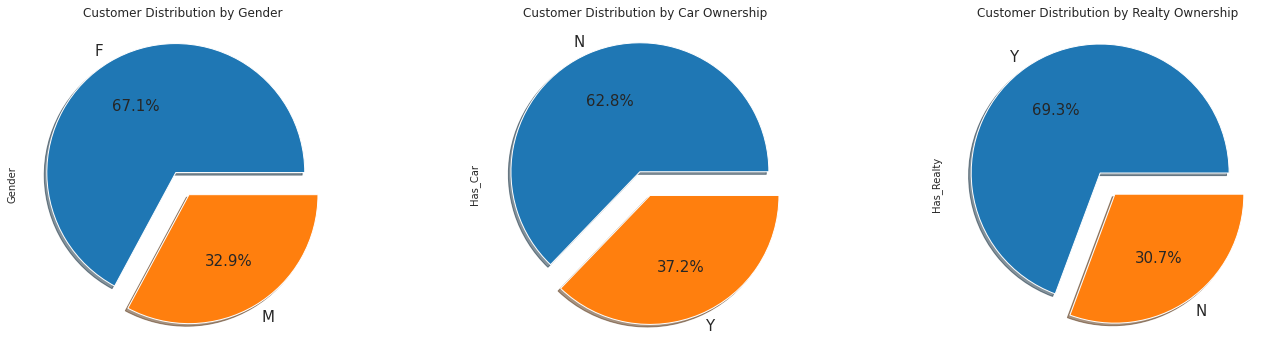

In [ ]:
# Helper function to plot pie-chart for categorical data
def pie_plot(cat_columns, data, titles):
    fig, ax = plt.subplots(1, len(cat_columns))
    fig.set_size_inches(20, 5)
    for i in range(len(cat_columns)):
        g = data[cat_columns[i]].value_counts().plot.pie(explode=[0.1, 0.1],
                                                          autopct='%1.1f%%',
                                                          shadow=True,
                                                          textprops={'fontsize': 15},
                                                          ax=ax[i])
        g.set_title(titles[i])
    plt.tight_layout()
    fig.show()

# title of the plots
titles = ["Customer Distribution by Gender",
          "Customer Distribution by Car Ownership", 
          "Customer Distribution by Realty Ownership"]
# Categorical features choosen
cat_columns = ['Gender', 'Has_Car', 'Has_Realty']

# Plot the pie-chart for the choosen cat cols
pie_plot(cat_columns, df, titles)


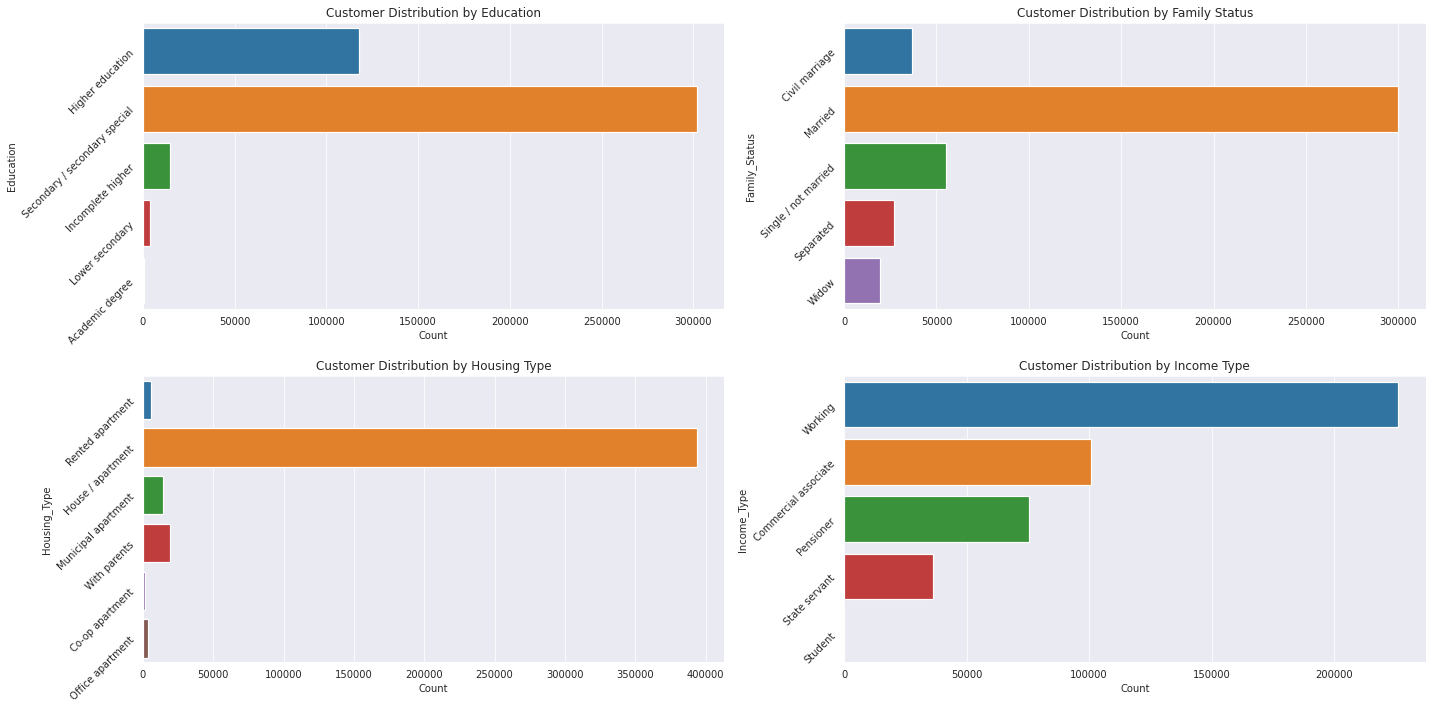

In [ ]:
# Helper function to plot bar plot for categorical data with multible values
def count_plot(cat_columns, data, title, xlabel):
    plt.figure(figsize=(20, 10))
    for i in range(len(cat_columns)):
        plt.subplot(2, 2, i + 1)
        fig = sns.countplot(y=data[cat_columns[i]], linewidth=1.2)
        fig.set_title(title[i])
        fig.set_xlabel(xlabel)
        fig.set_yticklabels(data[cat_columns[i]].unique().tolist(), rotation=45)  
    plt.tight_layout()
    plt.show()

# x-axis name
xlabel = "Count"

# title of the plots
titles = ["Customer Distribution by Education",
          "Customer Distribution by Family Status",
          "Customer Distribution by Housing Type",
          "Customer Distribution by Income Type"]
          
# Categorical features choosen
cat_columns = ["Education", "Family_Status", "Housing_Type", "Income_Type"]

# Plot the histogram for the choosen cat cols
count_plot(cat_columns, df, titles, xlabel)


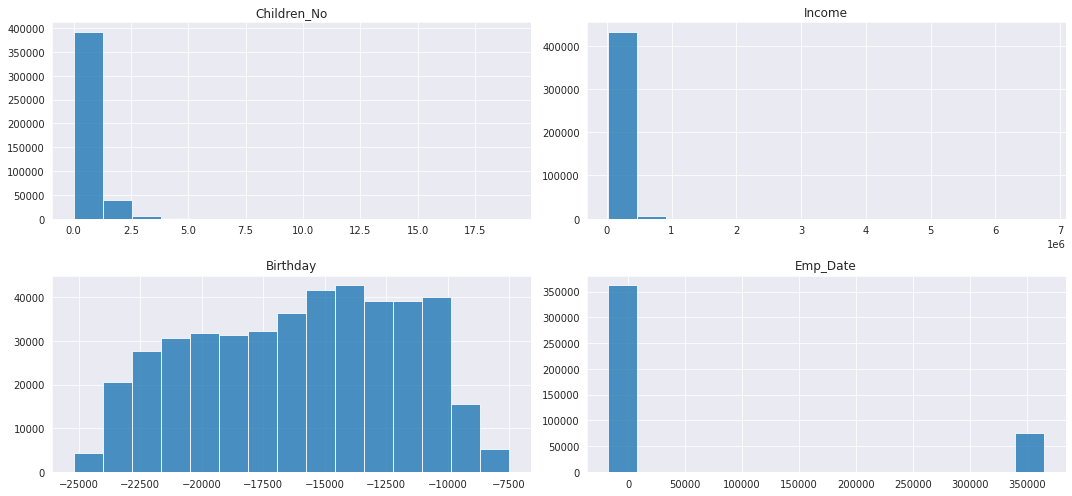

In [ ]:
# Function to plot histogram for categorical data to check the shape of distribution
def hist_plot(columns, data):
    data[columns].hist(bins=15, alpha=0.8)
    fig = plt.gcf()
    fig.set_size_inches(15, 7)
    plt.tight_layout()

# Features choosen to visualize
columns = ["Children_No", "Income", "Birthday", "Emp_Date"]

# Plot histogram
hist_plot(columns, df)


# Feature engineering

In [ ]:
# Get the categorical features 
categorical_cols = df.columns[df.dtypes == 'object'].tolist() 

# Print the unique values of categorical features
for col in df[categorical_cols].columns:
    print(col + ":")
    print(list(set(df[categorical_cols][col])))
    print("---------- \n")

Gender:
['M', 'F']
---------- 

Has_Car:
['N', 'Y']
---------- 

Has_Realty:
['N', 'Y']
---------- 

Income_Type:
['Pensioner', 'Working', 'Student', 'Commercial associate', 'State servant']
---------- 

Education:
['Academic degree', 'Higher education', 'Lower secondary', 'Incomplete higher', 'Secondary / secondary special']
---------- 

Family_Status:
['Civil marriage', 'Single / not married', 'Widow', 'Married', 'Separated']
---------- 

Housing_Type:
['Co-op apartment', 'Municipal apartment', 'House / apartment', 'Rented apartment', 'With parents', 'Office apartment']
---------- 



In [ ]:
# Get the month when users open their accounts
starting_month = pd.DataFrame(credit_record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
starting_month = starting_month.rename(columns={'MONTHS_BALANCE': 'Start_Month'}) 

customerDF = pd.merge(df, starting_month, how="left", on="ID") 

In [ ]:
# Converting categorical data into numerical
customerDF["Gender"]  = customerDF['Gender'].replace(['F', 'M'], [0, 1])
customerDF["Has_Car"] = customerDF["Has_Car"].replace(['Y', 'N'], [1, 0])

customerDF["Has_Realty"] = customerDF["Has_Realty"].replace(['Y', 'N'], [1, 0])

customerDF["Is_Working"] = customerDF["Income_Type"].replace(['Commercial associate', 'Pensioner',
                                                              'State servant', 'Working', 'Student'],
                                                             [1, 0, 1, 1, 0])
customerDF["Is_Married"] = customerDF["Family_Status"].replace(['Civil marriage', 'Separated',
                                                                'Single / not married', 'Widow', 'Married'],
                                                               [1, 0, 0, 0, 1])


In [ ]:
# Create new features Family_Size, Age & Experience from existing ones
customerDF["Family_Size"] = customerDF["Children_No"] \
                               + customerDF["Is_Married"].apply(lambda x: 2 if x == 1 else 1)

customerDF["Age"] = round((customerDF.Birthday / 365) * -1)

customerDF["Experience"] = customerDF.Emp_Date / 365
customerDF['Experience'] = customerDF['Experience'].apply(lambda x: int(x * -1) if x < 0 else 0)

# Drop Emp_Date, Birthday and Children_No columns
customerDF = customerDF.drop(columns=['Emp_Date','Birthday','Children_No'])


In [ ]:
# Adjust the values of some columns and map it to our dataframe
income_type = {'Commercial associate': 'Working',
               'State servant': 'Working',
               'Working': 'Working',
               'Pensioner': 'Pensioner',
               'Student': 'Student'}
customerDF["Income_Type"] = customerDF["Income_Type"].map(income_type)


education_type = {'Secondary / secondary special': 'Secondary',
                  'Lower secondary': 'Secondary',
                  'Higher education': 'Higher education',
                  'Incomplete higher': 'Higher education',
                  'Academic degree': 'Academic degree'}
customerDF["Education"] = customerDF["Education"].map(education_type)


family_status = {'Single / not married': 'Single',
                     'Separated': 'Single',
                     'Widow': 'Single',
                     'Civil marriage': 'Married',
                    'Married': 'Married'}
customerDF["Family_Status"] = customerDF["Family_Status"].map(family_status)


housing_type = {'House / apartment' : 'House / Apartment',
                   'With parents': 'With parents',
                    'Municipal apartment' : 'House / Apartment',
                    'Rented apartment': 'House / Apartment',
                    'Office apartment': 'House / Apartment',
                    'Co-op apartment': 'House / Apartment'}
customerDF["Housing_Type"] = customerDF["Housing_Type"].map(housing_type)


# Get the dummies of the previous adjusted features
customerDF = pd.get_dummies(customerDF, columns=['Income_Type', 'Education', 
                                                 'Family_Status', 'Housing_Type'])


In [ ]:
# Display the first five rows of customerDF table
customerDF.head()

,ID,Gender,Has_Car,Has_Realty,Income,Has_Mobile,Has_Work_Phone,Has_Phone,Has_Email,Family_Member_No,Start_Month,Is_Working,Is_Married,Family_Size,Age,Experience,Income_Type_Pensioner,Income_Type_Student,Income_Type_Working,Education_Academic degree,Education_Higher education,Education_Secondary,Family_Status_Married,Family_Status_Single,Housing_Type_House / Apartment,Housing_Type_With parents
0,5008804,1,1,1,427500.0,1,1,0,0,2.0,-15.0,1,1,2,33.0,12,0,0,1,0,1,0,1,0,1,0
1,5008805,1,1,1,427500.0,1,1,0,0,2.0,-14.0,1,1,2,33.0,12,0,0,1,0,1,0,1,0,1,0
2,5008806,1,1,1,112500.0,1,0,0,0,2.0,-29.0,1,1,2,59.0,3,0,0,1,0,0,1,1,0,1,0
3,5008808,0,0,1,270000.0,1,0,1,1,1.0,-4.0,1,0,1,52.0,8,0,0,1,0,0,1,0,1,1,0
4,5008809,0,0,1,270000.0,1,0,1,1,1.0,-26.0,1,0,1,52.0,8,0,0,1,0,0,1,0,1,1,0


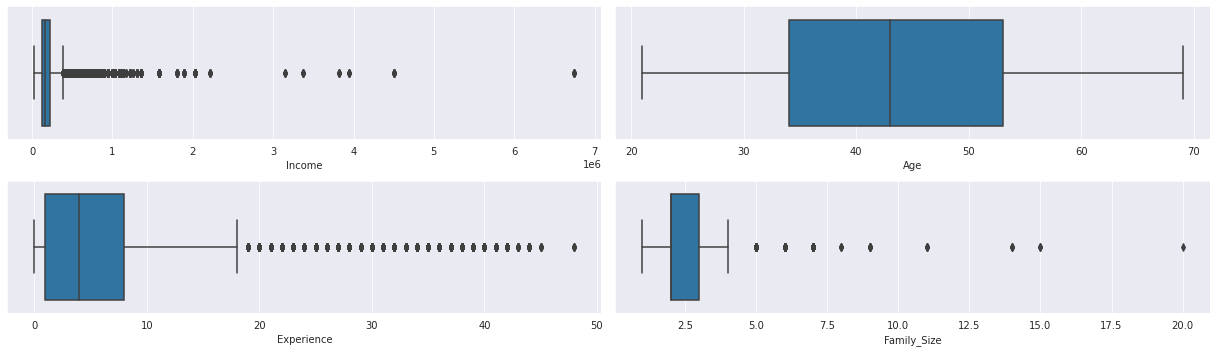

In [ ]:
# Function to plot box plot to check for outliers
def box_plot(data, numerical_cols, titles):
    plt.figure(figsize=(17, 5))
    for i in range(len(numerical_cols)):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(x=data[numerical_cols[i]])
    plt.tight_layout()
    plt.show()

# Columns choosen for checking
numerical_cols = ["Income", "Age", "Experience", "Family_Size"]
titles = ["Income", "Age", "Experience", "Family Member Count"]

# Plot box plot before removing outliers
box_plot(customerDF, numerical_cols, titles)

In [ ]:
# Function to calculate z-scores to check for outliers
def calculate_z_scores(data, columns):
    for col in columns:
        data[col + "_z_score"] = (data[col] - data[col].mean()) / data[col].std()
    return data

# Columns with outliers
columns = ["Income", "Experience", "Family_Size"]
newDF = calculate_z_scores(customerDF, columns)

# Remove outliers
filter_1 = newDF.Income_z_score.abs() <= 3.5
filter_2 = newDF.Experience_z_score.abs() <= 3.5
filter_3 = newDF.Family_Size_z_score.abs() <= 3.5
customer_apps_df = newDF[filter_1 & filter_2 & filter_3]
customer_apps_df.drop(columns= ["Income_z_score", "Experience_z_score",
                                "Family_Size_z_score"], inplace=True)

In [ ]:
# Print shapes before and after removing outliers
print("Number of apps =", customerDF.shape)
print("Number of apps after removing outliers =", customer_apps_df.shape)

Number of apps = (438510, 29)
Number of apps after removing outliers = (429279, 26)


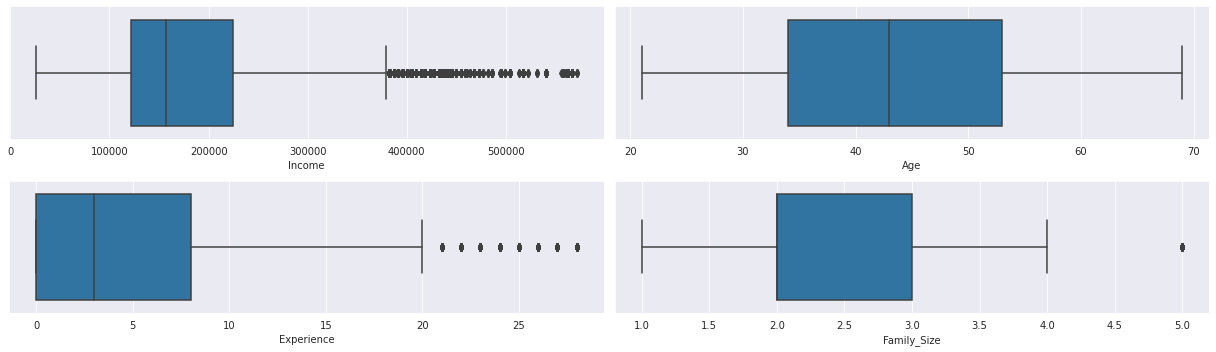

In [ ]:
# Plot box plot after removing outliers
box_plot(customer_apps_df, numerical_cols, titles)

In [ ]:
# Get the unique values of the STATUS column
status_uniques = credit_record['STATUS'].unique()
print('STATUS =', status_uniques)

STATUS = ['X' '0' 'C' '1' '2' '3' '4' '5']


In [ ]:
# Add new coulmn dep_value with all None on credit_record table
# Then, replace None values which has values on STATUS column in ('2', '3', '4' and '5')
# with 'Yes'
credit_record['dep_value'] = None
credit_record['dep_value'][credit_record['STATUS'] == '2'] = 'Yes' 
credit_record['dep_value'][credit_record['STATUS'] == '3'] = 'Yes' 
credit_record['dep_value'][credit_record['STATUS'] == '4'] = 'Yes' 
credit_record['dep_value'][credit_record['STATUS'] == '5'] = 'Yes' 


In [ ]:
# Create Table called record_count with the data grouped from credit_record table by ID 
# Then, Count values and assign 'Yes' for count above Zero, else 'No' on dep_value col
# Make dep_value tale has only the dep_value column
record_count = credit_record.groupby('ID').count()
record_count['dep_value'][record_count['dep_value']  > 0] = 'Yes' 
record_count['dep_value'][record_count['dep_value'] == 0] = 'No' 
record_count = record_count[['dep_value']]

record_count.head()

,dep_value
ID,
5001711,No
5001712,No
5001713,No
5001714,No
5001715,No


In [ ]:
# Create a pivot table with ID as index, MONTHS_BALANCE as cols and STATUS is the values
pivot_tb = credit_record.pivot(index='ID', columns='MONTHS_BALANCE', values='STATUS')

# Group credit_record data by ID 
grouped_ID = credit_record.groupby('ID')

# Add Open_Month, End_Month and Window columns in the pivot table
pivot_tb['Open_Month'] = grouped_ID['MONTHS_BALANCE'].min()
pivot_tb['End_Month']  = grouped_ID['MONTHS_BALANCE'].max()
pivot_tb['Window'] = pivot_tb['End_Month'] - pivot_tb['Open_Month'] + 1

# Shape of our pivot table
pivot_tb.shape

(45985, 64)

In [ ]:
# Counting number of paid offs
pivot_tb['Paid_OFF'] = pivot_tb[pivot_tb.iloc[:, 0: 61] == 'C'].count(axis=1)

# Counting number past dues
pivot_tb['Pastdue_1-29']  = pivot_tb[pivot_tb.iloc[:, 0: 61] == '0'].count(axis=1)
pivot_tb['Pastdue_30-59'] = pivot_tb[pivot_tb.iloc[:, 0: 61] == '1'].count(axis=1)
pivot_tb['Pastdue_60-89'] = pivot_tb[pivot_tb.iloc[:, 0: 61] == '2'].count(axis=1)
pivot_tb['Pastdue_90-119']   = pivot_tb[pivot_tb.iloc[:, 0: 61] == '3'].count(axis=1)
pivot_tb['Pastdue_120-149']  = pivot_tb[pivot_tb.iloc[:, 0: 61] == '4'].count(axis=1)
pivot_tb['Pastdue_over_150'] = pivot_tb[pivot_tb.iloc[:, 0: 61] == '5'].count(axis=1)

# Counting number of no loans
pivot_tb['NO_Loan'] = pivot_tb[pivot_tb.iloc[:, 0: 61] == 'X'].count(axis=1)


In [ ]:
# Setting ID column again to merge with Application data
pivot_tb['ID'] = pivot_tb.index

In [ ]:
# Display the first five rows of the pivot table
pivot_tb.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,-48,-47,-46,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,Open_Month,End_Month,Window,Paid_OFF,Pastdue_1-29,Pastdue_30-59,Pastdue_60-89,Pastdue_90-119,Pastdue_120-149,Pastdue_over_150,NO_Loan,ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,X,-3,0,4,0,3,0,0,0,0,0,1,5001711
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,C,C,C,C,C,C,C,C,C,-18,0,19,9,10,0,0,0,0,0,0,5001712
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,-21,0,22,0,0,0,0,0,0,0,22,5001713
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,-14,0,15,0,0,0,0,0,0,0,15,5001714
5001715,NaN,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,-59,0,60,0,0,0,0,0,0,0,60,5001715


In [ ]:
# Create an empty dataframe called target
target = pd.DataFrame()

# Add columns ID, Paid_OFF, NO_Loan and #_of_pastdues which is the sum of all the pastdues
target['ID'] = pivot_tb.index
target['Paid_OFF'] = pivot_tb['Paid_OFF'].values
target['#_of_pastdues'] = pivot_tb['Pastdue_1-29'].values \
                           + pivot_tb['Pastdue_30-59'].values \
                            + pivot_tb['Pastdue_60-89'].values \
                             + pivot_tb['Pastdue_90-119'].values \
                              + pivot_tb['Pastdue_120-149'].values \
                               + pivot_tb['Pastdue_over_150'].values                              
target['NO_Loan'] = pivot_tb['NO_Loan'].values

# Display the head of the target table
target.head()

,ID,Paid_OFF,#_of_pastdues,NO_Loan
0,5001711,0,3,1
1,5001712,9,10,0
2,5001713,0,0,22
3,5001714,0,0,15
4,5001715,0,0,60


In [ ]:
# Merge customer_apps_df table with target table
customer_apps_df1 = customer_apps_df.merge(target, how='inner', on='ID')

# Merge customer_apps_df1 table with record_count table
customer_apps_df2 = pd.merge(customer_apps_df1, record_count, how='inner', on='ID')

# Create target column with values equal to dep_value values
customer_apps_df2['target'] = customer_apps_df2['dep_value']

# Replace the values of 'Yes' with 1 and 'No' with 0
customer_apps_df2.loc[customer_apps_df2['target'] == 'Yes', 'target'] = 1
customer_apps_df2.loc[customer_apps_df2['target'] == 'No',  'target'] = 0

# Drop dep_value column from the customer_apps_df2 table
customer_apps_df2.drop(columns=["dep_value"], inplace=True)


In [ ]:
# Display the head of the customer_apps_df2 table
customer_apps_df2.head()

,ID,Gender,Has_Car,Has_Realty,Income,Has_Mobile,Has_Work_Phone,Has_Phone,Has_Email,Family_Member_No,Start_Month,Is_Working,Is_Married,Family_Size,Age,Experience,Income_Type_Pensioner,Income_Type_Student,Income_Type_Working,Education_Academic degree,Education_Higher education,Education_Secondary,Family_Status_Married,Family_Status_Single,Housing_Type_House / Apartment,Housing_Type_With parents,Paid_OFF,#_of_pastdues,NO_Loan,target
0,5008804,1,1,1,427500.0,1,1,0,0,2.0,-15.0,1,1,2,33.0,12,0,0,1,0,1,0,1,0,1,0,13,2,1,0
1,5008805,1,1,1,427500.0,1,1,0,0,2.0,-14.0,1,1,2,33.0,12,0,0,1,0,1,0,1,0,1,0,12,2,1,0
2,5008806,1,1,1,112500.0,1,0,0,0,2.0,-29.0,1,1,2,59.0,3,0,0,1,0,0,1,1,0,1,0,7,7,16,0
3,5008808,0,0,1,270000.0,1,0,1,1,1.0,-4.0,1,0,1,52.0,8,0,0,1,0,0,1,0,1,1,0,0,2,3,0
4,5008809,0,0,1,270000.0,1,0,1,1,1.0,-26.0,1,0,1,52.0,8,0,0,1,0,0,1,0,1,1,0,0,0,5,0


## Modeling

In [ ]:
# Assign the features and target
x = customer_apps_df2.iloc[:, :-1]
y = customer_apps_df2.target

In [ ]:
# Scale the data using StandardScaler
scaler = StandardScaler()
scaler.fit(x)

# Scalled features
X = pd.DataFrame(scaler.transform(x), columns=[x.columns])

In [ ]:
# Balance the data using SMOTE
y = y.astype('int')
X_balance, Y_balance = SMOTE().fit_resample(X, y)
X_balance = pd.DataFrame(X_balance, columns=X.columns)

In [ ]:
# Split the data ino train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balance, 
                                                    Y_balance, 
                                                    random_state=42, 
                                                    test_size=0.2)
# Shape of the training features
print(X_train.shape)

(56070, 29)


In [ ]:
# Built the model
clf = XGBClassifier(max_depth=12,
                   n_estimators=250,
                   min_child_weight=8, 
                   subsample=0.8, 
                   learning_rate=0.02,    
                   seed=42)

# Fit your model
clf.fit(X_train, y_train)

# Prediction
y_predict = clf.predict(X_test)

In [ ]:
# Confusion Matrix
conf_mx = confusion_matrix(y_test, y_predict)
print(conf_mx)

[[6912   98]
 [  60 6948]]


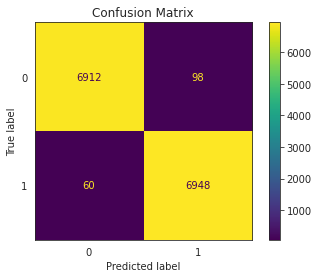

In [ ]:
# Plot Confusion Matrix
sns.set_style("white")
plot_confusion_matrix(clf, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Create table to store the Evaluations (Accuracy, Presicion, Recall, F1_score)
result_table = pd.DataFrame(columns=['Accuracy', 'Presicion', 'Recall', 'F1_score'])
result_table = result_table.append({'Clf': 'XGBoost',
                                    'Accuracy': accuracy_score(y_test, y_predict),
                                    'Presicion': precision_score(y_test, y_predict, average='weighted'),
                                    'Recall': recall_score(y_test, y_predict, average='weighted'),
                                    'F1_score': f1_score(y_test, y_predict, average='weighted')}, ignore_index=True)
result_table.set_index('Clf', inplace=True)

result_table.T

Clf,XGBoost
Accuracy,0.988729
Presicion,0.988743
Recall,0.988729
F1_score,0.988729
